<a href="https://colab.research.google.com/github/priyasha2011/quantum/blob/main/pennylanehybridmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane pennylane-qiskit torch torchvision tqdm captcha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 3

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from captcha.image import ImageCaptcha
from tqdm import tqdm
import time
import pennylane as qml
from pennylane import numpy as np


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [ ]:
import os
import random
from captcha.image import ImageCaptcha
from tqdm import tqdm
from PIL import Image

# Characters allowed in CAPTCHA
CHAR_SET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

# CAPTCHA properties
MIN_LENGTH = 4
MAX_LENGTH = 6
IMG_WIDTH = 180
IMG_HEIGHT = 60

# Number of samples per split
TRAIN_SIZE = 2000
VAL_SIZE = 500
TEST_SIZE = 500

# Output directories
BASE_DIR = "/content/captcha_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Create directories
for path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(path, exist_ok=True)

def random_captcha_text(min_len=MIN_LENGTH, max_len=MAX_LENGTH):
    length = random.randint(min_len, max_len)
    return ''.join(random.choices(CHAR_SET, k=length))

def generate_dataset(split_dir, num_samples):
    image_captcha = ImageCaptcha(width=IMG_WIDTH, height=IMG_HEIGHT)
    for _ in tqdm(range(num_samples), desc=f"Generating {split_dir.split('/')[-1]}"):
        text = random_captcha_text()
        image = image_captcha.generate_image(text)
        image = image.convert("RGB")
        file_path = os.path.join(split_dir, f"{text}.png")
        image.save(file_path)

generate_dataset(TRAIN_DIR, TRAIN_SIZE)
generate_dataset(VAL_DIR, VAL_SIZE)
generate_dataset(TEST_DIR, TEST_SIZE)


Generating test: 100%|██████████| 500/500 [00:04<00:00, 113.14it/s]


(np.float64(-0.5), np.float64(179.5), np.float64(59.5), np.float64(-0.5))

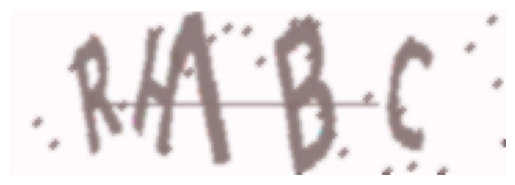

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
sample = Image.open(os.path.join(TRAIN_DIR, os.listdir(TRAIN_DIR)[0]))
plt.imshow(sample)
plt.axis("off")


In [ ]:
#pytorch dataset loader

CHAR_TO_IDX = {c: i for i, c in enumerate(CHAR_SET)}
IDX_TO_CHAR = {i: c for i, c in enumerate(CHAR_SET)}
NUM_CLASSES = len(CHAR_SET)
CAPTCHA_LEN = MAX_LENGTH


transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

class CaptchaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
      img_name = self.files[idx]
      label_text = os.path.splitext(img_name)[0]
      # pad shorter CAPTCHAs with 'A'
      if len(label_text) < MAX_LENGTH:
          label_text = label_text + "A" * (MAX_LENGTH - len(label_text))
      label = [CHAR_TO_IDX[c] for c in label_text]
      image = Image.open(os.path.join(self.root_dir, img_name))
      if self.transform:
          image = self.transform(image)
      return image, torch.tensor(label)



In [ ]:
#pennylane circuit

n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, n_qubits, 3))

    def forward(self, x):
        out = []
        for sample in x:
            q_out = quantum_circuit(sample, self.weights)
            # make sure it's a torch tensor
            if isinstance(q_out, (list, np.ndarray)):
                q_out = torch.tensor(q_out, dtype=torch.float32)
            out.append(q_out)
        return torch.stack(out)




In [ ]:
#hybrid model
class HybridCaptchaModel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, captcha_len=CAPTCHA_LEN):
        super().__init__()
        self.fc1 = nn.Linear(32*32, n_qubits)
        self.quantum = QuantumLayer()
        self.fc_out = nn.ModuleList([nn.Linear(n_qubits, num_classes) for _ in range(captcha_len)])

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.tanh(self.fc1(x))
        q_out = self.quantum(x)
        outs = [fc(q_out) for fc in self.fc_out]
        outs = torch.stack(outs, dim=1)
        return outs


In [ ]:
#train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridCaptchaModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_data = CaptchaDataset(TRAIN_DIR, transform)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)

EPOCHS = 50
start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)

        # Calculate loss across all characters
        loss = 0
        for i in range(CAPTCHA_LEN):
            loss += criterion(outputs[:, i, :], labels[:, i])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute accuracy
        preds = torch.argmax(outputs, dim=2)
        correct += (preds == labels).all(dim=1).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(train_loader):.4f} | Accuracy: {acc:.2f}%")

end_time = time.time()
print(f"\nTotal training time: {end_time - start_time:.2f} seconds")


Epoch 1/50 | Loss: 21.9184 | Accuracy: 0.00%
Epoch 2/50 | Loss: 21.4586 | Accuracy: 0.00%
Epoch 3/50 | Loss: 21.0308 | Accuracy: 0.00%
Epoch 4/50 | Loss: 20.6368 | Accuracy: 0.00%
Epoch 5/50 | Loss: 20.2801 | Accuracy: 0.00%
Epoch 6/50 | Loss: 19.9680 | Accuracy: 0.00%
Epoch 7/50 | Loss: 19.7050 | Accuracy: 0.00%
Epoch 8/50 | Loss: 19.4943 | Accuracy: 0.00%
Epoch 9/50 | Loss: 19.3334 | Accuracy: 0.00%
Epoch 10/50 | Loss: 19.2169 | Accuracy: 0.00%
Epoch 11/50 | Loss: 19.1357 | Accuracy: 0.00%
Epoch 12/50 | Loss: 19.0815 | Accuracy: 0.00%
Epoch 13/50 | Loss: 19.0469 | Accuracy: 0.00%
Epoch 14/50 | Loss: 19.0244 | Accuracy: 0.00%
Epoch 15/50 | Loss: 19.0108 | Accuracy: 0.00%
Epoch 16/50 | Loss: 19.0021 | Accuracy: 0.00%
Epoch 17/50 | Loss: 18.9971 | Accuracy: 0.00%
Epoch 18/50 | Loss: 18.9938 | Accuracy: 0.00%
Epoch 19/50 | Loss: 18.9920 | Accuracy: 0.00%
Epoch 20/50 | Loss: 18.9906 | Accuracy: 0.00%
Epoch 21/50 | Loss: 18.9898 | Accuracy: 0.00%
Epoch 22/50 | Loss: 18.9887 | Accuracy: 0.0

In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=2)
        mask = labels != -1
        correct += (preds[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

accuracy = 100 * correct / total
print(f"✅ CAPTCHA Character-Level Accuracy: {accuracy:.2f}%")


✅ CAPTCHA Character-Level Accuracy: 19.77%
